An extension of the ANN implemented in the book “Implementing a Multi-layer Artificial Neural Network from Scratch” of the book “Machine Learning with PyTorch and Scikit-Learn” by Raschka et al. (2022), Chapter 11 ([link to code](https://github.com/rasbt/machine-learning-book/blob/main/ch11/ch11.ipynb)).

The original code is being modified to create a 2-layer ANN. 

The first part is an exact copy of the author's code, except some changes in the split train/validation/test that were required in my task.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

# Rescale
X = ((X / 255.) - .5) * 2


from sklearn.model_selection import train_test_split

# different parameters than used in the book, according to my needs in the specific task

# Train: 70% (Validation: 10% of Train), Test: 30% 

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.1, random_state=123, stratify=y_temp)

# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y




(70000, 784)
(70000,)


The model part is a copy of the author's code, with revisions to __init__, the forward and the backward functions.

The most complex revision is in the backward function which is being used by the model for the backpropagation process. I added some annotations (e.g: [1]) that explain the calculations in the function.



In [ ]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary
    
class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        rng = np.random.RandomState(random_seed)
        
        # hidden 1
        self.weight_h1 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h1 = np.zeros(num_hidden)

        # hidden 2
        self.weight_h2 = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_hidden))
        self.bias_h2 = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):

        # Hidden layer 1
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)

        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: 
        ## dLoss/dOutWeights = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        
        # Notes for clarifications: ###############################
        #
        # L - loss function
        # W - Weights
        # A - Activation
        # Z - Before activation
        # dL/dW = derivative of loss by the weights = dL/dA * dA/dZ * dz/dW
        #         
        #         enumeration is followed in the code below
        #
        #         [1] dL/dA = d(y_A)**2 = 2.*(a_out - y_onehot) / y.shape[0] <-- the y.shape related to the sigma because of mini batches
        #         [2] dA/dZ = d(sigmoid(Z)) = a_out * (1. - a_out)
        #         [3] dZ/dW = d(A_hidden*W+b)/dW = A_hidden
        #
        #         delta = [1] * [2]
        #       
        ########################################################### 
        
        # input/output dim: [n_examples, n_classes]
        
        # [1]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        # [2]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        
        # [1] * [2]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        # [3]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # [1]*[2]*[3]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)

        # output dim: [n_classes, n_hidden]
        # sum([1]*[2]) – returned to be used in the bias calculation by the training function
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: 
        #
        # dLoss/dHidden2Weights = DeltaOut * dOutNet/dHidden2Act * dHidden2Act/dHidden2Net * dHidden2Net/dWeight2
        #
        # to compute the loss, using the delta_out from Part 1 above, 
        # briefly: delta_out * dZ/dA_hidden2 * dA_hidden2/dZ_hidden2  * dZ_hidden2/dW_hidden2
        #           [1]*[2]  *      [11]     *         [12]           *         [13]


        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out # dZ/dA_hidden. since z_out = A_hidden2 * W_out + b_out 

        # output dim: [n_examples, n_hidden]
 
        # [1]*[2] * [11]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        
        # [n_examples, n_hidden]
        # [12]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative
        
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        # [n_examples, n_hidden]#n_features]
        # [13] 
        d_z_h2__d_w_h2 = a_h1 #since z_h2 = wh2*ah1+b2
        
        # output dim: [n_hidden, n_hidden]#n_features]
        # [1]*[2]*[11]*[12]*[13]
        d_loss__d_w_h2 = np.dot(delta_h2.T, d_z_h2__d_w_h2)

        # sum([1]*[2]*[11]*[12]) – to be used in the bias calculation by the training function
        d_loss__d_b_h2 = np.sum(delta_h2, axis=0)


        #################################        
        # Part 3: 
        # dLoss/dHidden1Weights = DeltaOut * dOutNet/dHidden1Act * dHidde1nAct/dHidden1Net * dHidden1Net/dWeight1

        # delta_h2 * dZ_hidden2/dA_hidden1 * dA_hidden1/dZ_hidden1  * dZ_hidden1/dW_hidden1

        # [n_classes, n_hidden]
        d_z_h2__a_h1 = self.weight_h2 # dZ_hidden2/dA_hidden1. since z_hidden2 = A_hidden1 * W_hidden2 + b_hidden2 
        
        # output dim: [n_examples, n_hidden]
 
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        
        # [n_examples, n_hidden]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h1__d_w_h1 = x # since z_h1=x*w_h1+b
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)

        # returned to be used by the bias calculation in the training
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)


        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)

Running the model with 2 layers required some modifications of the train function, to include the weight updates of the 2nd layer

In [ ]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [ ]:
num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        # returns a generator
        yield X[batch_idx], y[batch_idx]


# testing the minibatch function: iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, _, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.0%


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.0%


In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 17.56% | Valid Acc: 17.65%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 28.97% | Valid Acc: 28.55%
Epoch: 003/050 | Train MSE: 0.08 | Train Acc: 33.44% | Valid Acc: 33.12%
Epoch: 004/050 | Train MSE: 0.07 | Train Acc: 48.04% | Valid Acc: 48.35%
Epoch: 005/050 | Train MSE: 0.06 | Train Acc: 66.71% | Valid Acc: 66.84%
Epoch: 006/050 | Train MSE: 0.05 | Train Acc: 71.34% | Valid Acc: 71.33%
Epoch: 007/050 | Train MSE: 0.04 | Train Acc: 80.38% | Valid Acc: 80.69%
Epoch: 008/050 | Train MSE: 0.03 | Train Acc: 84.59% | Valid Acc: 84.67%
Epoch: 009/050 | Train MSE: 0.03 | Train Acc: 86.75% | Valid Acc: 87.02%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 87.77% | Valid Acc: 88.10%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 88.36% | Valid Acc: 88.69%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 89.16% | Valid Acc: 89.10%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 89.70% | Valid Acc: 89.76%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 90.09

In [ ]:
print(epoch_loss)
print(epoch_train_acc)
print(epoch_valid_acc)

[0.08944289048254636, 0.08787089881874456, 0.0816715923642975, 0.06993977057940001, 0.058346356037590426, 0.04755625813090428, 0.03981542062978821, 0.03321015753075163, 0.02795875925285584, 0.024418634977475123, 0.02208927401074365, 0.02029009477075893, 0.019008999004807424, 0.01797805018867939, 0.0171173881841192, 0.01662662158086517, 0.015834543646573683, 0.015281329697380724, 0.014774876020054385, 0.014314281167972167, 0.013915460436119097, 0.013555342686363483, 0.01324931445778332, 0.012918120770240826, 0.012595853165919256, 0.012301162538197232, 0.012016970916130498, 0.011800451579203237, 0.011604654010857442, 0.011339003401050615, 0.011060346579611713, 0.010856256820904431, 0.010662331938058116, 0.010526909463250517, 0.010273525606190732, 0.010126939581723934, 0.009906943004245983, 0.009747061522647616, 0.00958373617689035, 0.009454080230246152, 0.009257945977263137, 0.009227951042003467, 0.009048952187160559, 0.008874601379068398, 0.008741087826211351, 0.00860989666754025, 0.008

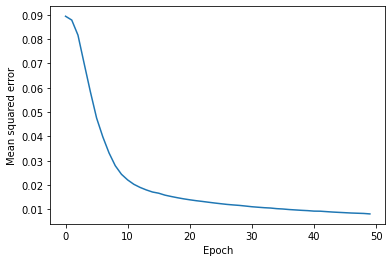

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

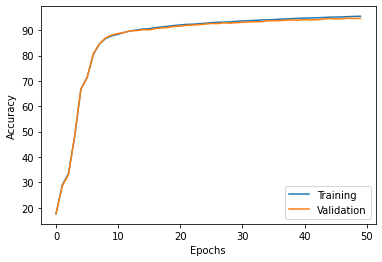

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()


In [ ]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.54%


In [ ]:
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import numpy as np

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize

def plot_roc(y_true, y_predicted, labels, y_true_is_one_hot=False, y_predicted_is_one_hot=False, plot_micro=True, plot_macro=True, plot_roc_per_class=True, plot_title="", save_plot=True):

    print("Plotting ROC curve....")
    n_classes = len(labels)

    if y_predicted_is_one_hot:
      Y_score = y_predicted #clf.decision_function(iris_X)
    else:
      Y_score = label_binarize(y_predicted, classes = labels) 
    if y_true_is_one_hot:
      Y_onehot = y_true
    else:
      Y_onehot = label_binarize(y_true, classes = labels)
    #Y_onehot = label_binarize(iris_Y, classes = labels)
    

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_onehot[:,i], Y_score[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_onehot.ravel(), Y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(roc_auc)

    # Plot all ROC curves
    fig = plt.figure(figsize=(12, 10), dpi=75)
    # set lineweight
    lw = 2

    # plot micro average
    if plot_micro:
      plt.plot(fpr["micro"], tpr["micro"],
              label='micro-average ROC curve (area = {0:0.3f})'
                    ''.format(roc_auc["micro"]),
              color='deeppink', linestyle=':', linewidth=4)

    # plot macro average
    if plot_macro:
      # print("fpr-macro:")
      # print(fpr["macro"])
      # print("tpr-macro:")
      # print(tpr["macro"])
      plt.plot(fpr["macro"], tpr["macro"],
              label='macro-average ROC curve (area = {0:0.3f})'
                    ''.format(roc_auc["macro"]),
              color='navy', linestyle=':', linewidth=4)

    # plot ROC for each class
    if plot_roc_per_class:
      colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
      for i, color in zip(range(n_classes), colors):    
          plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                  label='ROC curve of class {0} (area = {1:0.3f})'
                  ''.format(labels[i], roc_auc[i]))

    # plot diagnal line
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    if save_plot:
      fig.savefig("roc.png", bbox_inches='tight')

    print("ROC curve plotted.")

In [ ]:
dummy, dummy2, probas = model.forward(X_test)
test_pred = np.argmax(probas, axis=1)

In [ ]:
probas.shape

(21000, 10)

Plotting ROC curve....


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


{0: 0.9978327358589401, 1: 0.9981283506063038, 2: 0.9883124172497139, 3: 0.9894151176927093, 4: 0.9961116371712289, 5: 0.9850779417579311, 6: 0.998550056184203, 7: 0.9930899546401788, 8: 0.9932291426201719, 9: 0.9872662331396093, 'micro': 0.9931296006550769, 'macro': 0.9927254150979453}
ROC curve plotted.


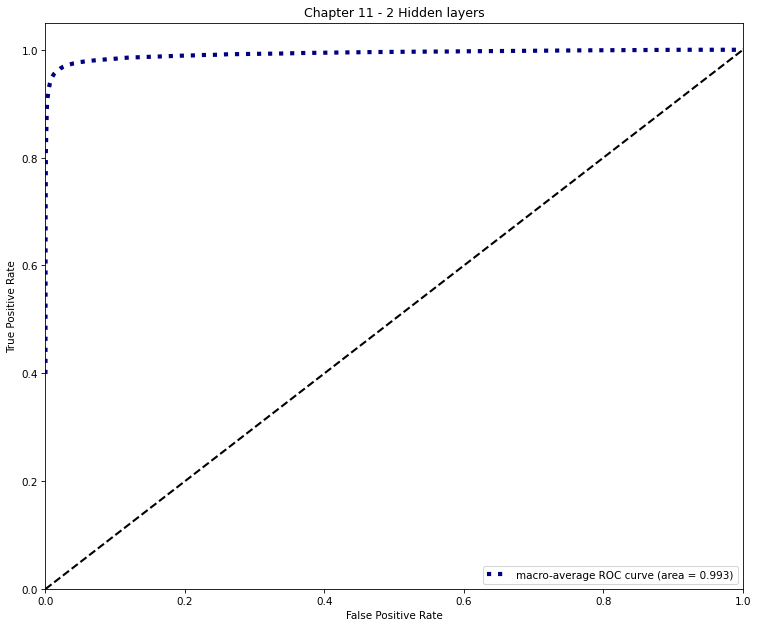

In [ ]:
plot_roc(y_test, probas, np.arange(10), y_true_is_one_hot=False, y_predicted_is_one_hot=True, plot_micro=False, plot_macro=True, plot_roc_per_class=False, plot_title="Chapter 11 - 2 Hidden layers", save_plot=True)

In [ ]:
# accuracy per class

df_comp = pd.DataFrame()
df_comp['y_test'] = y_test
df_comp['y_pred'] = test_pred
print("\n")
acc_per_class = []
for i in range(10):
  acc_per_class.append(df_comp[(df_comp['y_test'] == i) & (df_comp['y_pred']== i)]['y_test'].count() / df_comp[(df_comp['y_test'] == i)]['y_test'].count())

print(acc_per_class)



[0.9811685176243361, 0.9784172661870504, 0.9337148307105388, 0.9248366013071896, 0.945285784074255, 0.9123548046462513, 0.9641299079011149, 0.9456124314442413, 0.9326171875, 0.9214183037853378]
